In [1]:
# 1) Install deps (uses your repo requirements)
%pip install -q -r ../requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
# 2) Imports and data loading
import os, json
import numpy as np
import joblib
import matplotlib.pyplot as plt
import geopandas as gpd

from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_auc_score, average_precision_score

import pymc as pm
import arviz as az
from scipy.special import logit
from pathlib import Path

project_root = Path.cwd().parent

# --- Load required arrays
Xc = np.load(project_root / 'data/processed/X_coords.npy')

# Try critical labels first
if os.path.exists(project_root / "data/processed/y_labels_crit.npy"):
    y = np.load(project_root / "data/processed/y_labels_crit.npy")
    LABEL_SET = "critical"
else:
    y = np.load(project_root / "data/processed/y_labels.npy")
    LABEL_SET = "all"

print("Using label set:", LABEL_SET, "| positives:", y.sum(), "| rate:", float(y.mean()))

grid = joblib.load(project_root / 'data/processed/grid_gdf.joblib')

Using label set: critical | positives: 666 | rate: 0.08710436829714883


In [3]:
# 3) Feature Assembly
parts = [Xc]

# Optional geology
geo_path = project_root / 'data/processed/X_geo.npy'
if os.path.exists(geo_path):
    Xg = np.load(geo_path)
    if Xg.shape[0] == Xc.shape[0]:
        parts.append(Xg)
        print(f"Including geology: {Xg.shape[1]} cols")
    else:
        print("Skipping geology (row mismatch)")

# Optional gravity
grav_path = project_root / 'data/processed/X_gravity.npy'
if os.path.exists(grav_path):
    Xgrav = np.load(grav_path).reshape(-1, 1)
    if Xgrav.shape[0] == Xc.shape[0]:
        parts.append(Xgrav)
        print("Including gravity")

# Optional gravity gradient
grad_path = project_root / 'data/processed/X_gravity_grad.npy'
if os.path.exists(grad_path):
    Xgg = np.load(grad_path).reshape(-1, 1)
    if Xgg.shape[0] == Xc.shape[0]:
        parts.append(Xgg)
        print("Including gravity gradient")

# Optional geochemistry
geochem_path = project_root / "data/processed/X_geochem.npy"
if os.path.exists(geochem_path):
    Xgc = np.load(geochem_path)
    if Xgc.shape[0] == Xc.shape[0]:
        parts.append(Xgc)
        print(f"Including geochem: {Xgc.shape[1]} columns")
        
# Optional magnetic
if os.path.exists(project_root / "data/processed/X_mag.npy"):
    Xmag = np.load(project_root / "data/processed/X_mag.npy")
    if Xmag.shape[0] == Xc.shape[0]:   # or Xc.shape[0] if you build baseline first
        parts.append(Xmag)
        print(f"Including magnetics: {Xmag.shape[1]} cols")


X = np.hstack(parts)
print("X shape:", X.shape)

Including geology: 18 cols
Including gravity
Including gravity gradient
Including geochem: 8 columns
Including magnetics: 3 cols
X shape: (7646, 33)


In [4]:
# 4) Train calibrated RF
rf = RandomForestClassifier(
    n_estimators=500,
    max_features="sqrt",
    min_samples_leaf=1,
    n_jobs=-1,
    random_state=42
)
cal_rf = CalibratedClassifierCV(rf, method="isotonic", cv=5)
cal_rf.fit(X, y)

rf_probs = cal_rf.predict_proba(X)[:, 1]
auc_rf = roc_auc_score(y, rf_probs)
pr_auc = average_precision_score(y, rf_probs)
print(f"Calibrated RF — ROC AUC: {auc_rf:.3f} | PR AUC: {pr_auc:.3f}")

Calibrated RF — ROC AUC: 0.998 | PR AUC: 0.980


In [5]:
# 5) Prep features for Bayesian model
# Remove constant/near-constant columns and standardize
std = X.std(axis=0, ddof=0)
keep = std > 1e-8
if keep.sum() < X.shape[1]:
    print(f'Removed {X.shape[1]-keep.sum()} near-constant columns for stability')
Xb = X[:, keep]
Xb = (Xb - Xb.mean(axis=0)) / Xb.std(axis=0)

# Intercept prior: base rate
p0 = float(np.clip(y.mean(), 1e-4, 1-1e-4))
mu_intercept = logit(p0)

Removed 2 near-constant columns for stability


In [6]:
# 6) Bayesian logistic regression (PyMC)
with pm.Model() as model:
    beta = pm.Normal('beta', 0.0, 0.5, shape=Xb.shape[1])
    intercept = pm.Normal('intercept', mu_intercept, 2.0)
    logits = intercept + pm.math.dot(Xb, beta)
    y_obs = pm.Bernoulli('y_obs', logit_p=logits, observed=y)
    trace = pm.sample(
        draws=1000, tune=1500, chains=4, cores=4,
        init='jitter+adapt_diag', target_accept=0.95, random_seed=42,
        progressbar=True
    )

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, intercept]
NUTS: [beta, intercept]


Output()

Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 175 seconds.


In [7]:
# 7) Recompute posterior probabilities safely from samples
# Build (chains, draws, n_features) arrays then matrix-multiply with Xb.T
beta_samp = trace.posterior['beta'].values   # (chains, draws, n_feat)
int_samp = trace.posterior['intercept'].values  # (chains, draws)
# logits = intercept + beta @ Xb.T
logits = int_samp[..., None] + np.einsum("cdf,nf->cdn", beta_samp, Xb)
post_p = 1.0 / (1.0 + np.exp(-logits))  # sigmoid
bayes_mean = post_p.mean(axis=(0,1))
bayes_std  = post_p.std(axis=(0,1))

auc_bayes = roc_auc_score(y, bayes_mean)
print('Bayes AUC:', round(auc_bayes, 3))

Bayes AUC: 0.687


Saved c:\Users\angel\ore-exploration-ml\ore-exploration-ml\figures\model_comparison.png


(<Figure size 1800x600 with 6 Axes>,
 array([<Axes: title={'center': 'Random Forest (AUC=1.00)'}, xlabel='Longitude', ylabel='Latitude'>,
        <Axes: title={'center': 'Bayesian Mean (AUC=0.69)'}, xlabel='Longitude', ylabel='Latitude'>,
        <Axes: title={'center': 'Bayesian Uncertainty (Std Dev)'}, xlabel='Longitude', ylabel='Latitude'>],
       dtype=object))

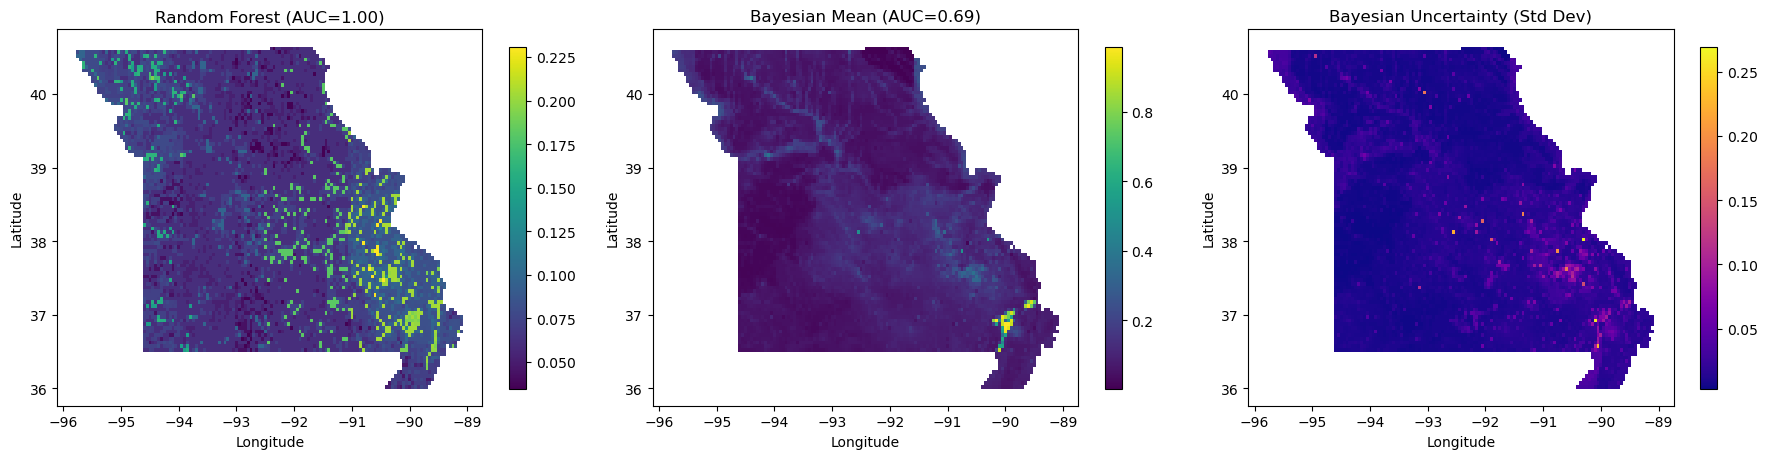

In [8]:
# 8) Plot side-by-side and save
def plot_panel(grid, layers, titles, cmaps, out_path):
    fig, axs = plt.subplots(1, len(layers), figsize=(18,6))
    for i, (vals, title, cmap) in enumerate(zip(layers, titles, cmaps)):
        g = grid.copy()
        g['val'] = vals
        g.plot(column='val', ax=axs[i], cmap=cmap, legend=True, legend_kwds={'shrink':0.6})
        axs[i].set_title(title)
        axs[i].set_xlabel('Longitude'); axs[i].set_ylabel('Latitude')
    plt.tight_layout()
    os.makedirs(project_root / 'figures', exist_ok=True)
    plt.savefig(out_path, dpi=200)
    print('Saved', out_path)
    return fig, axs

titles = [f'Random Forest (AUC={auc_rf:.2f})',
          f'Bayesian Mean (AUC={auc_bayes:.2f})',
          'Bayesian Uncertainty (Std Dev)']
cmaps = ['viridis', 'viridis', 'plasma']
plot_panel(grid, [rf_probs, bayes_mean, bayes_std], titles, cmaps, project_root / 'figures/model_comparison.png')